In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.model_selection import cross_val_score,cross_validate,ShuffleSplit,StratifiedKFold,train_test_split,KFold,GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/bank-additional-full.csv", delimiter=";")

print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))

print("Number of columns before dropping duration: %d" % df.shape[1] )
df = df.drop(['duration'], axis=1)
print("Number of columns after dropping duration: %s" % df.shape[1] )

rows_contains_unknown = df[df.eq('unknown').any(axis=1)].index
df = df.drop(index=rows_contains_unknown)

print("Number of rows after dropping unknowns: %d" % len(df))
df = pd.get_dummies(df)
print("Number of columns after get_dummies: %d" % df.shape[1])
df = df.drop(['y_no'], axis=1)
print("Number of columns after dropping y_no: %d" % df.shape[1])

X = df.iloc[:, :56]
y = df.iloc[:, -1:]

Number of rows before dropping NaNs: 41188
Number of rows after dropping NaNs: 41188
Number of columns before dropping duration: 21
Number of columns after dropping duration: 20
Number of rows after dropping unknowns: 30488
Number of columns after get_dummies: 58
Number of columns after dropping y_no: 57


In [7]:
random_clf = RandomForestClassifier(n_estimators=400,max_depth=6,random_state=60)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
random_clf.fit(X_train, y_train.values.ravel())
scores_random = cross_val_score(random_clf, X=X_train,y=y_train.values.ravel(),cv=10,scoring='f1')
scores_r = scores_random.mean()
print ("scores_random:", scores_r)

('scores_random:', 0.30608043817668096)


[0.18944582 0.17418222 0.10859227 0.09390174 0.08200895 0.07949342
 0.06214353 0.02536476 0.0196152  0.01683755]
['nr.employed' 'euribor3m' 'pdays' 'poutcome_success' 'emp.var.rate'
 'cons.conf.idx' 'cons.price.idx' 'previous' 'age' 'poutcome_failure']


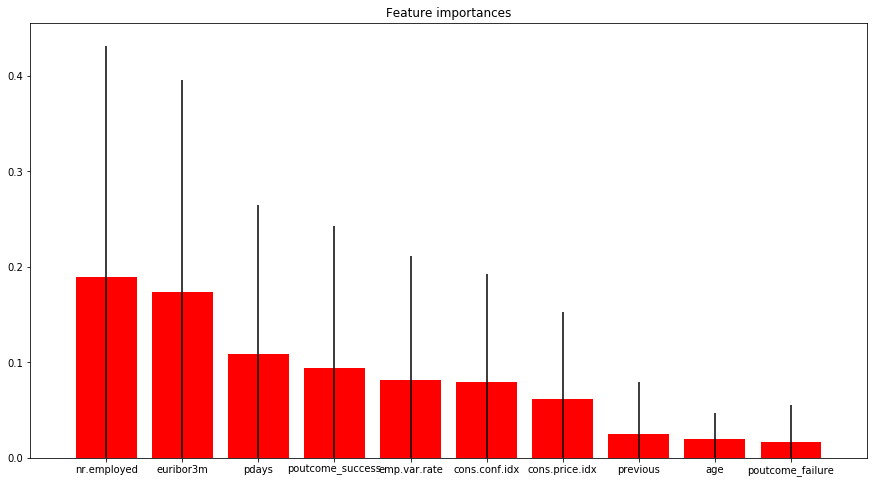

In [8]:
importances = random_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print(importances[indices][:10])
print(np.array(df.columns)[indices][:10])

fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices][:10],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(10), np.array(df.columns)[indices][:10])
plt.xlim([-1, 10])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

fig.set_size_inches(15, 8)